In [1]:
import os
import time
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

# import tensorflow as tf
# from tensorflow.python.ops.numpy_ops import np_config

import tensorcircuit as tc
from opt_einsum import contract

import jax
from jax import numpy as jnp
from jax import random

from src.QDDPM_jax import setDiffusionDataOneQubit, QDDPM
from src.distance_jax import naturalDistance, WassDistance, sinkhornDistance

rc('text', usetex=True)
rc('axes', linewidth=3)

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


In [3]:
n = 1
T = 20
N = 10000

In [4]:
def circleYGen(N_train, seed=0):
    # generate random quantum states from RY(\phi)|0>
    # assume uniform distribution
    key = random.PRNGKey(seed)
    phis = random.uniform(key, shape=(N_train,), minval=0, maxval=2*np.pi)
    states = jnp.stack((jnp.cos(phis), jnp.sin(phis)))
    states = jnp.transpose(states)

    return jnp.complex64(states)

def circleXGen(N_train, seed=0):
    # generate random quantum states from RY(\phi)|0>
    # assume uniform distribution
    key = random.PRNGKey(seed)
    phis = random.uniform(key, shape=(N_train,), minval=0, maxval=2*np.pi)
    states = jnp.stack((jnp.cos(phis), -1j * jnp.sin(phis)))
    states = jnp.transpose(states)
    
    return states

distance measure behavior in the forward process

In [5]:
diff_hs = jnp.linspace(0.2, 1.6, T)
X = circleYGen(N)

t0 = time.time()
Xout = np.zeros((T + 1, N, 2**n), dtype=np.complex64)
Xout[0] = X
for t in range(1, T + 1):
    Xout[t] = setDiffusionDataOneQubit(X, diff_hs[:t])
    print("Step {}".format(t))

t1 = time.time()

print("Time elapsed: {:.4f} seconds".format(t1 - t0))

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Time elapsed: 7.0574 seconds


In [6]:
data_path = "./data/QDDPM/circle/n1"
file_name = 'circleYDiff_n1T%d_N%d.npy'%(T, N)
if not os.path.exists(data_path):
    os.makedirs(data_path)

jnp.save(os.path.join(data_path, file_name).replace("\\","/"), Xout)

Text(0.5, 0, '$t$')

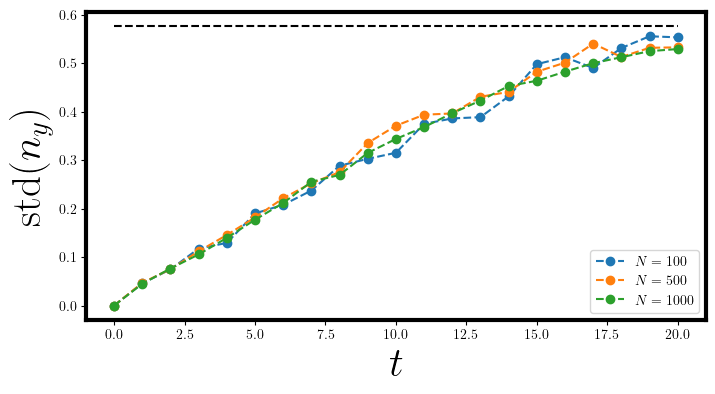

In [7]:
# plot the standard deviation of ny evolution
sy = jnp.array([[0,-1j],[1j,0]])
X = jnp.load('data/QDDPM/circle/n1/circleYDiff_n1T%d_N%d.npy'%(T, N))
ys = contract('tmi, ij, tmj->tm', X.conj(), sy, X)

Ns = [100, 500, 1000]
plt.figure(figsize=(8, 4))
for i in range(3):
    idx = random.choice(random.PRNGKey(i), N, shape=(Ns[i], ), replace=False)
    ysample = ys[:,idx]
    plt.plot(range(21), jnp.std(ysample, axis=1), 'o--', label=r'$N=%d$'%Ns[i])
plt.plot(range(21), 1 / jnp.sqrt(3) * jnp.ones(21), '--', c='k')
plt.legend()
plt.ylabel(r'${\rm std}(n_y)$', fontsize=30)
plt.xlabel(r'$t$', fontsize=30)

In [17]:
# calculate the distance
T = 20
Ns = [100, 500, 1000]
batchnum = 10
X = jnp.load('data/QDDPM/circle/n1/circleYDiff_n1T%d_N%d.npy'%(T, N))
X = jnp.swapaxes(X, 0, 1)

for i in range(3):
    Xshuff = random.permutation(random.PRNGKey(i), X, independent=True)
    Xref = circleYGen(Ns[i])
    nd = np.zeros((T+1, batchnum))
    wd = np.zeros((T+1, batchnum))
    shd = np.zeros((T+1, batchnum))
    # shd_log = np.zeros((T+1, batchnum))
    t0 = time.time()
    for k in range(batchnum):
        Xsample = X[k * Ns[i]:(k + 1) * Ns[i]]
        for t in range(T + 1):
            nd[t, k] = naturalDistance(Xref, Xsample[:, t])
            wd[t, k] = WassDistance(Xref, Xsample[:, t]).item()
            shd[t, k] = sinkhornDistance(Xref, Xsample[:, t], reg=0.01).item()
    
    t1 = time.time()
    print("Sample size: {};".format(Ns[i]), 
          "Time used: {:.4f} seconds".format(t1 - t0))
    np.save('data/QDDPM/circle/n1/circleYDiffnd_n1T20_N%d.npy'%(Ns[i]), nd)
    np.save('data/QDDPM/circle/n1/circleYDiffwd_n1T20_N%d.npy'%(Ns[i]), wd)
    np.save('data/QDDPM/circle/n1/circleYDiffshd_n1T20_N%d.npy'%(Ns[i]), shd)
    # np.save('data/QDDPM/circle/n1/circleYDiffshdlog_n1T20_N%d.npy'%(Ns[i]), shd_log)

Sample size: 100; Time used: 3.2136 seconds
Sample size: 500; Time used: 52.3133 seconds
Sample size: 1000; Time used: 185.8578 seconds


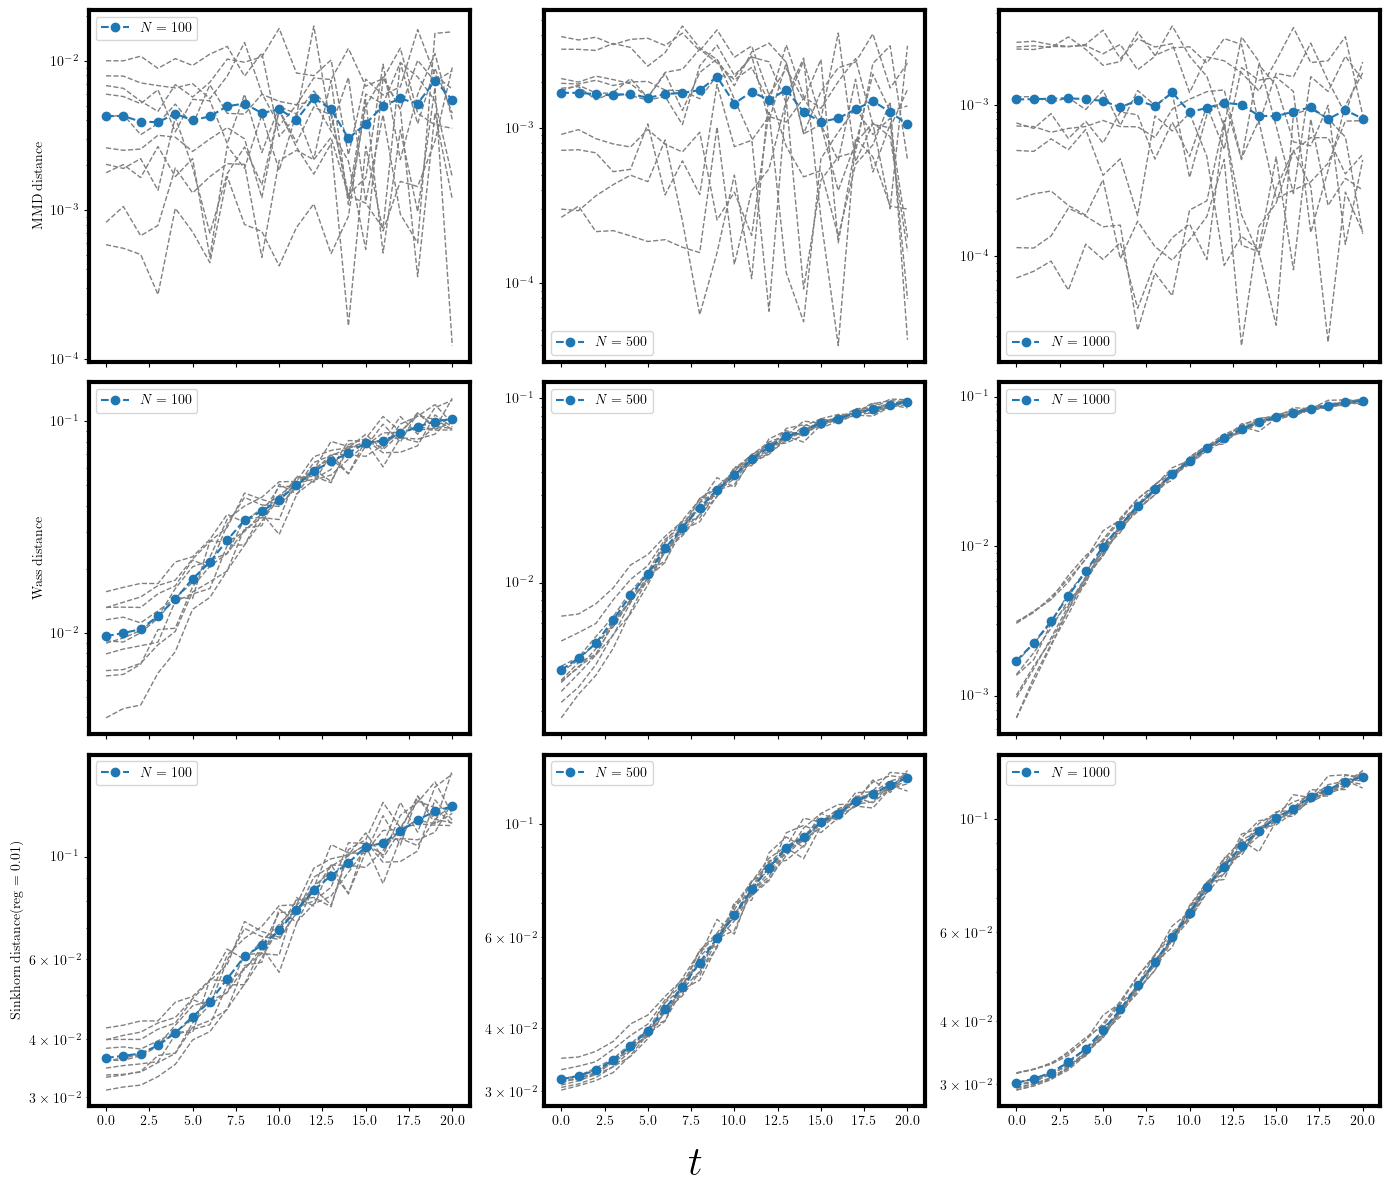

In [18]:
# plot the distance evolution (natural disance)
T = 20
Ns = [100, 500, 1000]
dist_method = ['nd', 'wd', 'shd']
batchnum = 10
fig, axs = plt.subplots(3, 3, figsize=(14, 12), sharex=True)
for i in range(3):
    for k in range(3):
        ds = np.load('data/QDDPM/circle/n1/circleYDiff%s_n1T20_N%d.npy'%(dist_method[k], Ns[i]))
        axs[k,i].plot(range(T+1), ds, '--', c='grey', lw=1)
        axs[k,i].plot(range(T+1), np.mean(ds, axis=1), 'o--', label=r'$N=%d$'%Ns[i])
        axs[k,i].legend()
        axs[k,i].set_yscale('log')
axs[0,0].set_ylabel(r'$\rm MMD\:distance$')
axs[1,0].set_ylabel(r'$\rm Wass\:distance$')
axs[2,0].set_ylabel(r'$\rm Sinkhorn\:distance(reg=0.01)$')
fig.supxlabel(r'$t$', fontsize=30)
plt.tight_layout()

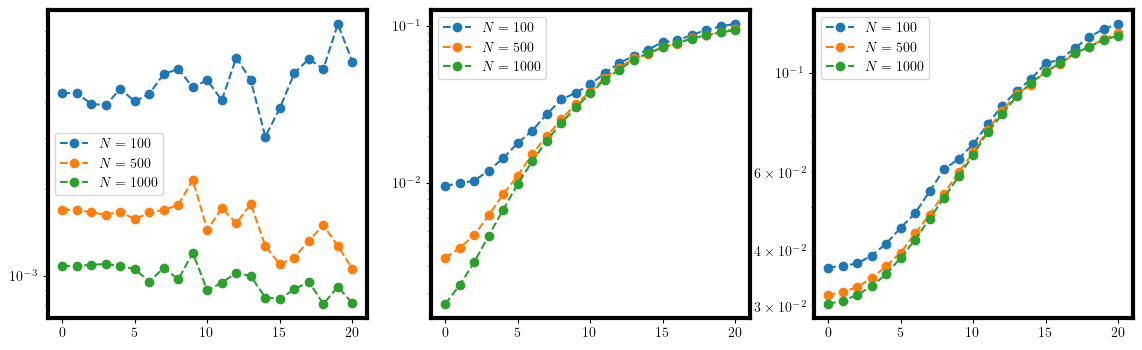

In [19]:
# plot to compare with sample size
T = 20
Ns = [100, 500, 1000]
dist_method = ['nd', 'wd', 'shd']
batchnum = 10
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
cl = ['b', 'orange', 'm']
ml = ['^', 'o', 'D']
for i in range(3):
    for k in range(3):
        ds = np.load('data/QDDPM/circle/n1/circleYDiff%s_n1T20_N%d.npy'%(dist_method[k], Ns[i]))
        axs[k].plot(range(T+1), np.mean(ds, axis=1), 'o--', label=r'$N=%d$'%Ns[i])
        axs[k].legend()
        axs[k].set_yscale('log')

In [ ]:
def batchTraining_t(model, t, inputs_T, params_tot, Ndata, batchsize, epochs, dis_measure='nat'):
    '''
    the batch trianing for the backward PQC at step t
    Args:
    model: the QDDPM
    t: diffusion step
    params_tot: collection of PQC parameters for steps > t 
    Ndata: number of samples in training data set
    batchsize: number of samples in one batch
    epochs: number of iterations
    dis_measure: the distance measure to compare two distributions of quantum states
    dis_params: potential hyper-parameters for distance measure
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history
    ystd_hist = [] # record of std of bloch-y cooredinates

    # select loss function
    if dis_measure == 'nat':
        # natural distance
        loss_func = naturalDistance
    elif dis_measure == 'wd':
        # Wassastein distance
        loss_func = WassDistance

    sy = tf.constant([[0 + 0j, -1j], [1j, 0 + 0j]])
    
    # np.random.seed()
    tf.random.set_seed(None)
    params_t = tf.Variable(tf.random.normal([2 * model.n_tot * model.L]))

    # set optimizer and learning rate decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.01, 200, 0.8, staircase=True)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    for _ in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]
        
        with tf.GradientTape() as tape:
            output_t = model.backwardOutput_t(input_tplus1, params_t)
            loss = loss_func(output_t, true_data)

        grads = tape.gradient(loss, [params_t])
        optimizer.apply_gradients(zip(grads, [params_t]))
        ys = contract('mi,ij,mj->m', jnp.conj(output_t), sy, output_t).real

        loss_hist.append(tf.stop_gradient(loss)) # record the current loss
        ystd_hist.append(tf.std(ys))
        
    return tf.stop_gradient(params_t), tf.squeeze(tf.stack(loss_hist)), tf.squeeze(tf.stack(ystd_hist))

In [ ]:
# denoise training parameters
n, na = 1, 1
T = 20
L = 4
Ndata = 500
batchsize = 100
epochs = 3000
method = 'wd'

In [ ]:
model = QDDPM(n=n, na=na, T=T, L=L)
states_diff = jnp.load('data/QDDPM/circle/n%d/circleYDiff_n%dT%d_N10000.npy'%(n, n, T))
model.set_diffusionSet(states_diff)

t = 19
params_tot = np.zeros((20, 2*(n+na)*L))
for tt in range(t+1, 20):
    params_tot[tt] = np.load('data/QDDPM/circle/n1/record/QDDPMcircleYparams_n1na1T20L%d_t%d_%s.npy'
                             %(L, tt, method))

params, loss, ystd = batchTraining_t(model, t, params_tot, Ndata, batchsize, epochs, method) # missing inputs_T?


In [ ]:
# collect result
n, na = 1, 1
T = 20
L = 4
N_train = 1000
method = 'wd'
loss_tot = np.zeros((T, 3400))
params_tot = np.zeros((T, 2*(n+na)*L))
ystd_tot = np.zeros((T, 3400))
for t in range(T):
    loss_each = np.load('data/QDDPM/circle/n1/record_wd/QDDPMcircleYloss_n1na1T20L4_t%d_%s.npy'%(t, method))
    loss_tot[t, :len(loss_each)] = loss_each
    params_tot[t] = np.load('data/QDDPM/circle/n1/record_wd/QDDPMcircleYparams_n1na1T20L4_t%d_%s.npy'%(t, method))
    ystd_each = np.load('data/QDDPM/circle/n1/record_wd/QDDPMcircleYystd_n1na1T20L4_t%d_%s.npy'%(t, method))
    ystd_tot[t, :len(ystd_each)] = ystd_each

np.save('data/QDDPM/circle/n1/QDDPMcircleYloss_n1na1T20L4_Ntr1000_%s.npy'%method, loss_tot)
np.save('data/QDDPM/circle/n1/QDDPMcircleYparams_n1na1T20L4_Ntr1000_%s.npy'%method, params_tot)
np.save('data/QDDPM/circle/n1/QDDPMcircleYystd_n1na1T20L4_Ntr1000_%s.npy'%method, ystd_tot)

Generate training and test data set at step T

In [ ]:
def scrambleState(phis, T):
    '''
    obtain the one-qubit state through T-step scrambling
    assume input is trivial |0>
    Args:
    phis: the single-qubit rotation angles in diffusion circuit
    '''
    c = tc.Circuit(n)
    for t in range(T):
        # single qubit rotations
        c.rz(0, theta=phis[3*t])
        c.ry(0, theta=phis[3*t+1])
        c.rz(0, theta=phis[3*n*t+2])
    return c.state()

In [ ]:
n = 1
T = 20

K = tc.set_backend('pytorch')

X = np.zeros(2**n)
X[0] = 1
X = torch.from_numpy(X).cfloat()

scramble_vmap = K.vmap(partial(scrambleState, T=T), vectorized_argnums=0)

In [ ]:
np.random.seed(17)
phis_tr = torch.from_numpy(np.random.uniform(0, 2*np.pi, (Ndata, 3*n*T))).float()
inputs_T_tr = scramble_vmap(phis_tr)

np.random.seed(19)
phis_te = torch.from_numpy(np.random.uniform(0, 2*np.pi, (Ndata, 3*n*T))).float()
inputs_T_te = scramble_vmap(phis_te)


In [ ]:
# generate training & test data
n, na = 1, 1
T = 20
L = 4
Ndata = 1000
method = 'wd'

params_tot = np.load('data/QDDPM/circle/n%d/QDDPMcircleYparams_n%dna%dT%dL%d_%s.npy'%(n, n, na, T, L, method))

model = QDDPM_cpu(n=n, na=na, T=T, L=L)
dataset_train = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n].numpy()
dataset_test = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n].numpy()
np.save('data/QDDPM/circle/n%d/QDDPMcircleYtrainGen_n%dna%dT%dL%d_%s.npy'%(n, n, na, T, L, method), dataset_train)
np.save('data/QDDPM/circle/n%d/QDDPMcircleYtestGen_n%dna%dT%dL%d_%s.npy'%(n, n, na, T, L, method), dataset_test)

In [ ]:
# plot training and test result
T = 20
Ndata = 1000
method = 'wd'
states_diff = np.load('data/QDDPM/circle/n1/circleYDiff_n1T20_N10000.npy')
gen_data_tr = np.load('data/QDDPM/circle/n1/QDDPMcircleYtraingen_n1na1T20L4_%s.npy'%method)
gen_data_te = np.load('data/QDDPM/circle/n1/QDDPMcircleYtestgen_n1na1T20L4_%s.npy'%method)

sy = np.array([[0,-1j], [1j, 0]], dtype=np.complex64)
ys_diff = np.real(contract('tmi, ij, tmj->tm', states_diff.conj(), sy, states_diff))
ys_train = np.real(contract('tmi, ij, tmj->tm', gen_data_tr.conj(), sy, gen_data_tr))
ys_test = np.real(contract('tmi, ij, tmj->tm', gen_data_te.conj(), sy, gen_data_te))

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i in range(2):
    axs[i].plot(range(T+1), np.mean(np.abs(ys_diff), axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
                zorder=5, label=r'$\rm diff$')

axs[0].plot(range(T+1), np.mean(np.abs(ys_train), axis=1), 'o--', markersize=5, mfc='white', lw=2, c='b', 
            zorder=5, label=r'$\rm train$')
axs[0].fill_between(range(T+1), np.mean(np.abs(ys_train), axis=1)-np.std(np.abs(ys_train), axis=1), 
                    np.mean(np.abs(ys_train), axis=1)+np.std(np.abs(ys_train), axis=1), color='b', alpha=0.1)
axs[0].plot(range(T+1), 1/np.sqrt(3)*np.ones(T+1), '--', lw=2, c='orange')

axs[1].plot(range(T+1), np.mean(np.abs(ys_test), axis=1), 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', 
            zorder=5, label=r'$\rm test$')
axs[1].fill_between(range(T+1), np.mean(np.abs(ys_test), axis=1)-np.std(np.abs(ys_test), axis=1), 
                    np.mean(np.abs(ys_test), axis=1)+np.std(np.abs(ys_test), axis=1), color='forestgreen', alpha=0.1)
axs[1].plot(range(T+1), 1/np.sqrt(3)*np.ones(T+1), '--', lw=2, c='orange')

axs[0].set_ylabel(r'$|n_y|$', fontsize=30)
for i in range(2):
    axs[i].legend(fontsize=20, framealpha=0)
    axs[i].set_ylim(-0.05, 1.05)
    axs[i].set_xticks(np.arange(0, T+1,5))
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
fig.supxlabel(r'$t$', fontsize=30)
plt.tight_layout()
plt.savefig('figures/QDDPMcircleYny_n1na1T20L4_%s.pdf'%method, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# plot training loss history
n, na = 1, 1
T = 20
L = 4
N_train, N_test = 1000, 1000
method = 'wd'
loss = np.load('data/QDDPM/circle/n1/QDDPMCircleYloss_n1na1T20L4_wd.npy')
fig, axs = plt.subplots(5, 4, figsize=(16, 14), sharex=True, sharey=True)
for i in range(20):
    idx = max(np.where(loss[i] > 0)[0])
    axs[i//4, i%4].plot(loss[i, :idx+1], lw=2)
    axs[i//4, i%4].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//4, i%4].text(x=2500, y=0.2, s=r'$t=%d$'%(i+1), fontsize=25)
    axs[i//4, i%4].set_yscale('log')
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$\mathcal{L}(t)$', fontsize=30)
plt.tight_layout()
plt.savefig('figures/QDDPMcircleYloss_n1na1T20L4_%s.pdf'%method, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# plot history of bloch-y standard deviation
n, na = 1, 1
T = 20
L = 4
N_train, N_test = 1000, 1000
ystd = np.load('data/QDDPM/circle/n1/QDDPMCircleYystd_n1na1T20L4_wd.npy')
fig, axs = plt.subplots(5, 4, figsize=(16, 14), sharex=True, sharey=True)
for i in range(20):
    idx = max(np.where(ystd[i] > 0)[0])
    axs[i//4, i%4].plot(ystd[i, :idx+1], lw=2)
    axs[i//4, i%4].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//4, i%4].text(x=2500, y=0.6, s=r'$t=%d$'%(i+1), fontsize=25)
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'${\rm Std}(n_y)$', fontsize=30)
plt.tight_layout()

Comparison with quantum direct transport

In [ ]:
def QDTbatchtraining(model, inputs_T, Ndata, batchsize, epochs, dis_measure='wd', dis_params={}):
    '''
    the trianing for the batch backward QDT
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    dis_measure: the distance measure to compare two distributions of quantum states
    dis_params: potential hyper-parameters for distance measure
    '''
    input_tplus1 = torch.zeros((Ndata, 2**model.n_tot)).cfloat()
    input_tplus1[:,:2**model.n] = model.randomSampleGeneration(Ndata) # prepare input
    states_diff = torch.stack((model.states_diff[0], model.states_diff[-1]))
    loss_hist = [] # record of training history
    ystd_hist = [] # record of std of bloch-y cooredinates

    batchnum = Ndata//batchsize # the number of batches

    sy = torch.from_numpy(np.array([[0,-1j], [1j, 0]])).cfloat()
    
    np.random.seed()
    params_t = torch.tensor(np.random.randn(2*model.n_tot*model.L), dtype=torch.float32, requires_grad=True)
    
    # set optimizer and learning rate decay
    optimizer = torch.optim.SGD(params=(params_t, ), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=400, gamma=0.5)

    for step in range(epochs):
        b_indices = np.split(np.random.permutation(Ndata), batchnum)
        for b in range(batchnum):
            # optimize over each batch
            optimizer.zero_grad()
            td_indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
            true_data = states_diff[0, td_indices]
            output = model.backwardOutput_t(input_tplus1[b_indices[b]], params_t, mseq=False)
            if dis_measure == 'nat':
                # natural distance
                loss = naturalDistance(output, true_data)
            elif dis_measure == 'dd':
                # diffusion distance
                loss = diffusionDistance(output, true_data, band_width=dis_params['bandwidth'])
            elif dis_measure == 'wd':
                # Wassastein distance
                loss = WassDistance(output, true_data)
            elif dis_measure == 'shd':
                # sinkhorn distance
                loss = sinkhornDistance(output, true_data, reg=dis_params['reg'], log=dis_params['log'])
            
            loss.backward()
            optimizer.step()

        scheduler.step()

        loss_hist.append(loss.detach()) # record the current loss
        ys = torch.real(contract('mi,ij,mj->m', output.detach().conj(), sy, output.detach()))
        ystd_hist.append(torch.std(ys))
        
        if (step+1)%200 == 0 or not step:
            print(step+1, loss_hist[step], ystd_hist[step])
            
    return params_t.detach(), torch.stack(loss_hist).squeeze(), torch.stack(ystd_hist).squeeze()

In [ ]:
n = 1
T = 20
Ndata = 1000

diffModel = DiffusionModel(n, T, Ndata)
X = np.zeros((Ndata, 2**n))
X[:,0] = 1
X = torch.from_numpy(X).cfloat()
np.random.seed(17)
phis = torch.from_numpy(np.random.uniform(0, 2*np.pi, (Ndata, 3*n*T))).float()

inputs_T = torch.zeros((Ndata, 2**n)).cfloat()
for i in range(Ndata):
   inputs_T[i] = diffModel.scrambleCircuit_t(T, X[i], phis[i])


T = 20
L = 80
Ndata = 1000
batchsize = 200
epochs = 5000
method = 'wd'

model = QDDPM_cpu(n=1, na=1, T=20, L=L)
states_diff = np.load('data/QDDPM/circle/n%d/circleYDiff_n%dT%d_N10000.npy'%(n, n, T))
model.set_diffusionSet(states_diff)

params, loss, ystd = QDTbatchtraining(model, inputs_T, Ndata, batchsize, epochs, method)

Generate training and test data

In [ ]:
n = 1
T = 20

K = tc.set_backend('pytorch')

X = np.zeros(2**n)
X[0] = 1
X = torch.from_numpy(X).cfloat()

scramble_vmap = K.vmap(partial(scrambleState, T=T), vectorized_argnums=0)

In [ ]:
Ndata = 1000

np.random.seed(17)
phis_tr = torch.from_numpy(np.random.uniform(0, 2*np.pi, (Ndata, 3*n*T))).float()
inputs_T_tr = scramble_vmap(phis_tr)

np.random.seed(19)
phis_te = torch.from_numpy(np.random.uniform(0, 2*np.pi, (Ndata, 3*n*T))).float()
inputs_T_te = scramble_vmap(phis_te)

In [ ]:
# generate training & test data
n, na = 1, 1
T = 20
L = 80
Ndata = 1000
method = 'wd'

params_tot = np.load('data/QDT/circle/n%d/QDTcircleYparams_n%dna%dT%dL%d_%s.npy'%(n, n, na, T, L, method))
params_tot = params_tot.reshape((1, len(params_tot)))

model = QDDPM_cpu(n=n, na=na, T=1, L=L)
dataset_train = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n].numpy()
dataset_test = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n].numpy()
np.save('data/QDT/circle/n%d/QDTcircleYtrainGen_n%dna%dT%dL%d_%s.npy'%(n, n, na, T, L, method), dataset_train)
np.save('data/QDT/circle/n%d/QDTcircleYtestGen_n%dna%dT%dL%d_%s.npy'%(n, n, na, T, L, method), dataset_test)

In [ ]:
# plot training and test result of QDT
T = 20
L = 80
Ndata = 1000
method = 'wd'
states_diff = np.load('data/QDDPM/circle/n1/circleYDiff_n1T20_N10000.npy')
gen_data_tr = np.load('data/QDT/circle/n1/QDTcircleYtraingen_n1na1T20L80_%s.npy'%method)
gen_data_te = np.load('data/QDT/circle/n1/QDTcircleYtestgen_n1na1T20L80_%s.npy'%method)

sy = np.array([[0,-1j], [1j, 0]], dtype=np.complex64)
ys_diff = np.real(contract('tmi, ij, tmj->tm', states_diff.conj(), sy, states_diff))
ys_train = np.real(contract('tmi, ij, tmj->tm', gen_data_tr.conj(), sy, gen_data_tr))
ys_test = np.real(contract('tmi, ij, tmj->tm', gen_data_te.conj(), sy, gen_data_te))

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i in range(2):
    axs[i].plot(range(T+1), np.mean(np.abs(ys_diff), axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
                zorder=5, label=r'$\rm diff$')

axs[0].errorbar([0, T], np.mean(np.abs(ys_train), axis=1), yerr=np.std(np.abs(ys_train), axis=1), fmt='o--', 
                markersize=10, mfc='white', barsabove=True, lw=2, c='b', zorder=5, label=r'$\rm train$')
    
axs[0].plot(range(T+1), 1/np.sqrt(3)*np.ones(T+1), '--', lw=2, c='orange')

axs[1].errorbar([0, T], np.mean(np.abs(ys_test), axis=1), yerr=np.std(np.abs(ys_test), axis=1), fmt='o--', 
                markersize=10, mfc='white', barsabove=True, lw=2, c='forestgreen', zorder=5, label=r'$\rm test$')

axs[1].plot(range(T+1), 1/np.sqrt(3)*np.ones(T+1), '--', lw=2, c='orange')

axs[0].set_ylabel(r'$|n_y|$', fontsize=30)
for i in range(2):
    axs[i].legend(fontsize=20, framealpha=0)
    axs[i].set_ylim(-0.05, 1.05)
    axs[i].set_xticks(np.arange(0, T+1,5))
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
fig.supxlabel(r'$t$', fontsize=30)
plt.tight_layout()
plt.savefig('figures/QDTcircleYny_n1na1T20L%d_%s.pdf'%(L, method), bbox_inches='tight')
plt.show()
plt.close()